# $\hspace{27pt}$ Shri Ramdeobaba College of Engineering and Management

### $\hspace{145pt}$  Deep Learning [ Mini Project : P - 9 ]

## Name : Suyash Kanhed

## Section : A4  $\hspace{50pt}$           Roll No. : 62

## Date : 13/04/2025

## -------------------------------------------------------------------------------------------------------------

# $\hspace{108pt}$ Brain-Tumor Segmentaion

## -------------------------------------------------------------------------------------------------------------

## Introduction

3D Brain Tumor Segmentation
Comparing three 3D approaches:
1. 3D U-Net
2. 3D Attention U-Net
3. 3D Transformer-Enhanced Model

----------

## 1. Dataset Preparation (3D Synthetic MRI Data)

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Multiply
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def generate_3d_mri(num_samples=16, vol_size=128):
    scans = np.random.rand(num_samples, vol_size, vol_size, vol_size, 1).astype(np.float32) * 0.5
    masks = np.zeros((num_samples, vol_size, vol_size, vol_size, 1), dtype=np.float32)

    # Add random 3D tumors
    for i in range(num_samples):
        center = np.random.randint(30, 98, size=3)
        radius = np.random.randint(5, 15)
        xx, yy, zz = np.ogrid[:vol_size, :vol_size, :vol_size]
        distance = np.sqrt((xx - center[0])**2 + (yy - center[1])**2 + (zz - center[2])**2)
        masks[i, distance <= radius] = 1.0
        scans[i, distance <= radius] += 0.3  # Simulate tumor intensity

    return scans, masks

x_train, y_train = generate_3d_mri(num_samples=16)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

## Model 1  :   3D U-Net

In [14]:
def build_3d_unet(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((2,2,2))(c1)

    c2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(p1)
    c2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((2,2,2))(c2)

    # Bottleneck
    c3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(p2)
    c3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling3D((2,2,2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(32, (3,3,3), activation='relu', padding='same')(u4)
    c4 = Conv3D(32, (3,3,3), activation='relu', padding='same')(c4)

    u5 = UpSampling3D((2,2,2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(16, (3,3,3), activation='relu', padding='same')(u5)
    c5 = Conv3D(16, (3,3,3), activation='relu', padding='same')(c5)

    outputs = Conv3D(1, (1,1,1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

model_unet = build_3d_unet()
model_unet.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

history_unet = model_unet.fit(x_train, y_train,
                             validation_data=(x_val, y_val),
                             batch_size=1,
                             epochs=5)


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5382 - loss: 0.6913 - mean_io_u_2: 0.4990 - val_accuracy: 0.9989 - val_loss: 0.6546 - val_mean_io_u_2: 0.4997
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 631ms/step - accuracy: 0.9970 - loss: 0.5679 - mean_io_u_2: 0.4986 - val_accuracy: 0.9994 - val_loss: 0.0559 - val_mean_io_u_2: 0.4997
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 652ms/step - accuracy: 0.9971 - loss: 0.0532 - mean_io_u_2: 0.4985 - val_accuracy: 0.9994 - val_loss: 0.0181 - val_mean_io_u_2: 0.4997
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step - accuracy: 0.9978 - loss: 0.0568 - mean_io_u_2: 0.4989 - val_accuracy: 0.9994 - val_loss: 0.0135 - val_mean_io_u_2: 0.4997
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - accuracy: 0.9977 - loss: 0.0332 - mean_io_u_2: 0.4988 - val_accuracy: 0.9994 - val_loss: 0.0174 - val_mean_io_u_2: 0.4997


## Model 2  : 3D Attention U-Net

In [16]:
class AttentionGate3D(layers.Layer):
    def __init__(self, filters):
        super(AttentionGate3D, self).__init__()
        self.W_g = Conv3D(filters, 1, padding='same')
        self.W_x = Conv3D(filters, 1, padding='same')
        self.psi = Conv3D(1, 1, padding='same', activation='sigmoid')

    def call(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = tf.nn.relu(g1 + x1)
        psi = self.psi(psi)
        return Multiply()([x, psi])

def build_3d_attention_unet(input_shape=(128,128,128,1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((2,2,2))(c1)

    c2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(p1)
    c2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((2,2,2))(c2)

    # Bottleneck
    c3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(p2)
    c3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(c3)

    # Decoder with Attention
    u4 = UpSampling3D((2,2,2))(c3)
    att4 = AttentionGate3D(32)(c2, u4)
    u4 = concatenate([att4, u4])
    c4 = Conv3D(32, (3,3,3), activation='relu', padding='same')(u4)
    c4 = Conv3D(32, (3,3,3), activation='relu', padding='same')(c4)

    u5 = UpSampling3D((2,2,2))(c4)
    att5 = AttentionGate3D(16)(c1, u5)
    u5 = concatenate([att5, u5])
    c5 = Conv3D(16, (3,3,3), activation='relu', padding='same')(u5)
    c5 = Conv3D(16, (3,3,3), activation='relu', padding='same')(c5)

    outputs = Conv3D(1, (1,1,1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

model_att_unet = build_3d_attention_unet()
model_att_unet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

history_att = model_att_unet.fit(x_train, y_train,
                                validation_data=(x_val, y_val),
                                batch_size=1,
                                epochs=5)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9887 - loss: 0.6372 - mean_io_u_3: 0.4989 - val_accuracy: 0.9994 - val_loss: 0.1489 - val_mean_io_u_3: 0.4997
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 746ms/step - accuracy: 0.9979 - loss: 0.0888 - mean_io_u_3: 0.4989 - val_accuracy: 0.9994 - val_loss: 0.0200 - val_mean_io_u_3: 0.4997
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 758ms/step - accuracy: 0.9967 - loss: 0.0919 - mean_io_u_3: 0.4984 - val_accuracy: 0.9994 - val_loss: 0.0220 - val_mean_io_u_3: 0.4997
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 763ms/step - accuracy: 0.9976 - loss: 0.0405 - mean_io_u_3: 0.4988 - val_accuracy: 0.9994 - val_loss: 0.0177 - val_mean_io_u_3: 0.4997
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 761ms/step - accuracy: 0.9976 - loss: 0.0346 - mean_io_u_3: 0.4988 - val_accuracy: 0.9994 - val_loss: 0.0172 - val_mean_io_u_3: 0.4997


## Model 3  : 3D Transformer-Enhanced Model

In [4]:
# Ensure that you have the correct versions of TensorFlow and TensorFlow Addons
!pip install --upgrade tensorflow tensorflow-addons

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Transformer Block without using tensorflow_addons
class TransformerBlock3D(layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super(TransformerBlock3D, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(key_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

class PatchEncoder3D(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder3D, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def build_3d_transformer_unet(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    x = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(inputs)
    x = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((8,8,8))(x)  # (16, 16, 16)

    # Flatten patches and apply Transformer
    x = layers.Reshape((16*16*16, 32))(x)  # (4096, 32)
    x = PatchEncoder3D(num_patches=4096, projection_dim=64)(x)
    x = TransformerBlock3D(num_heads=4, key_dim=64, ff_dim=128)(x)

    # Decoder
    x = layers.Reshape((16, 16, 16, 64))(x)
    x = layers.UpSampling3D((8,8,8))(x)  # back to 128x128x128
    x = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(x)
    outputs = layers.Conv3D(1, (1,1,1), activation='sigmoid')(x)

    return Model(inputs, outputs)

# Create the model
model_transformer = build_3d_transformer_unet()
model_transformer.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Dummy training data
x_train = np.random.rand(2, 128, 128, 128, 1).astype(np.float32)
y_train = np.random.randint(0, 2, size=(2, 128, 128, 128, 1)).astype(np.float32)

x_val = np.random.rand(1, 128, 128, 128, 1).astype(np.float32)
y_val = np.random.randint(0, 2, size=(1, 128, 128, 128, 1)).astype(np.float32)

# Train
history = model_transformer.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=1,
    epochs=2
)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4998 - loss: 0.8475 - mean_io_u_4: 0.2499 - val_accuracy: 0.5004 - val_loss: 0.7057 - val_mean_io_u_4: 0.2499
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - accuracy: 0.5000 - loss: 0.7192 - mean_io_u_4: 0.2499 - val_accuracy: 0.5003 - val_loss: 0.7601 - val_mean_io_u_4: 0.2499


## Visualization & Evaluation

U-Net Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


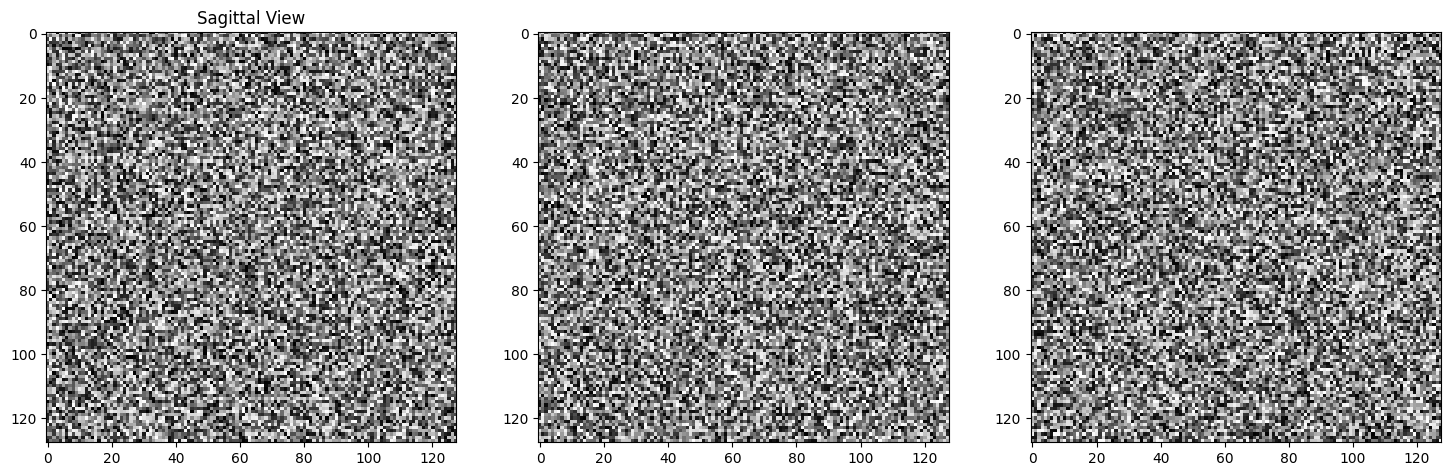

Attention U-Net Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


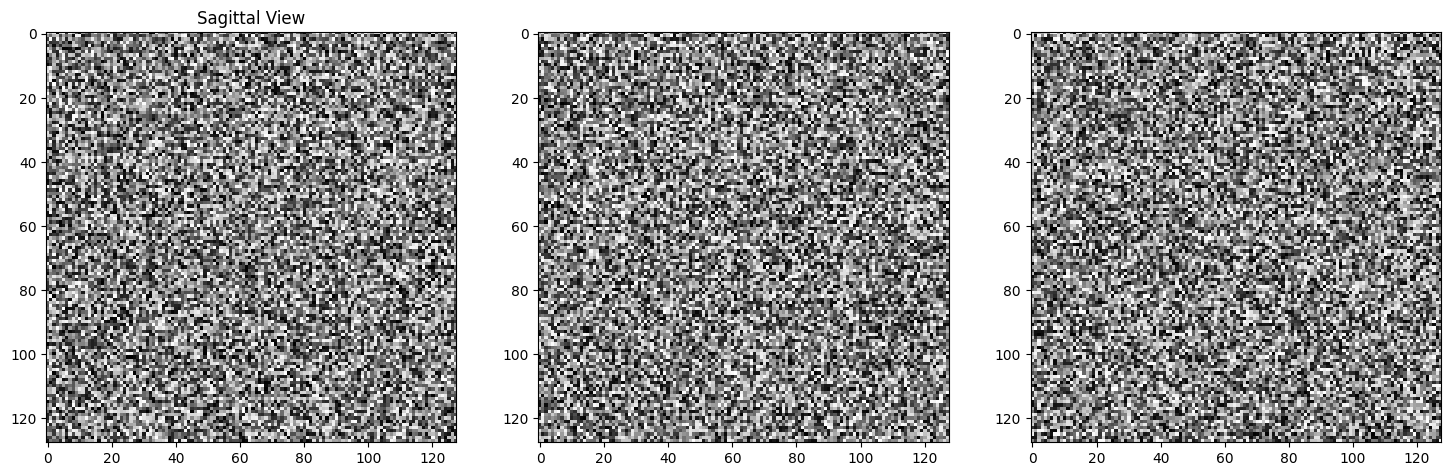

Transformer Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


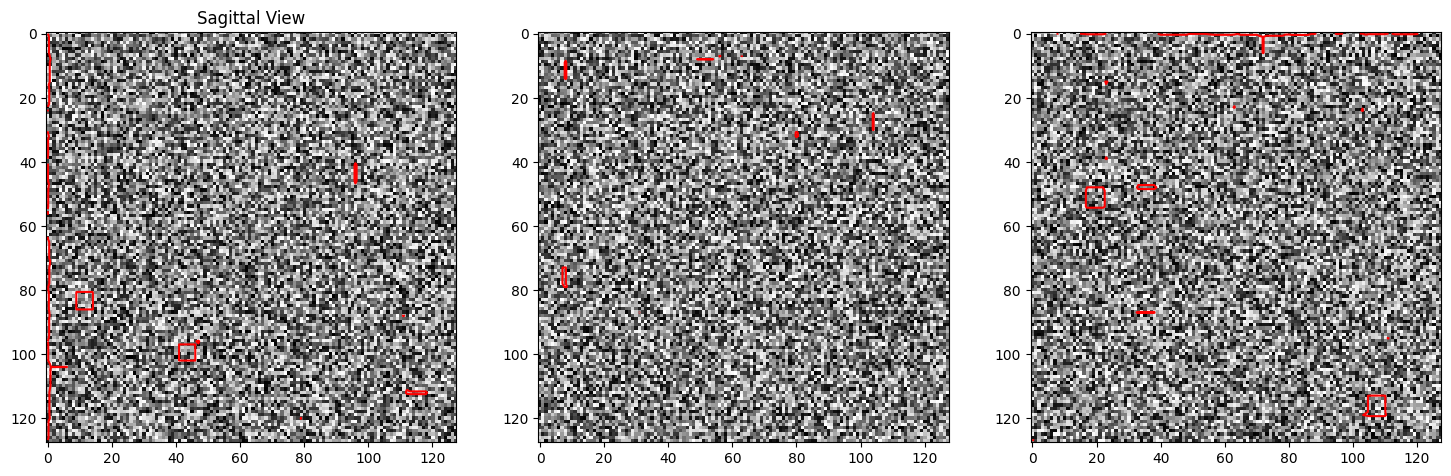

In [18]:
def plot_3d_slices(model, vol_idx=0):
    sample = x_val[vol_idx:vol_idx+1]
    pred = model.predict(sample)[0,...,0]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Axial
    ax[0].imshow(sample[0,:,:,64,0], cmap='gray')
    ax[0].contour(pred[:,:,64], levels=[0.5], colors='red')
    ax[0].set_title('Axial View')

    # Coronal
    ax[1].imshow(sample[0,:,64,:,0], cmap='gray')
    ax[1].contour(pred[:,64,:], levels=[0.5], colors='red')
    ax[0].set_title('Coronal View')

    # Sagittal
    ax[2].imshow(sample[0,64,:,:,0], cmap='gray')
    ax[2].contour(pred[64,:,:], levels=[0.5], colors='red')
    ax[0].set_title('Sagittal View')

    plt.show()

print("U-Net Predictions:")
plot_3d_slices(model_unet)

print("Attention U-Net Predictions:")
plot_3d_slices(model_att_unet)

print("Transformer Predictions:")
plot_3d_slices(model_transformer)

## Performance Comparison

Model Evaluation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
3D U-Net: Dice=0.005, IoU=0.250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
3D Attention U-Net: Dice=0.004, IoU=0.250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
3D Transformer: Dice=0.570, IoU=0.254


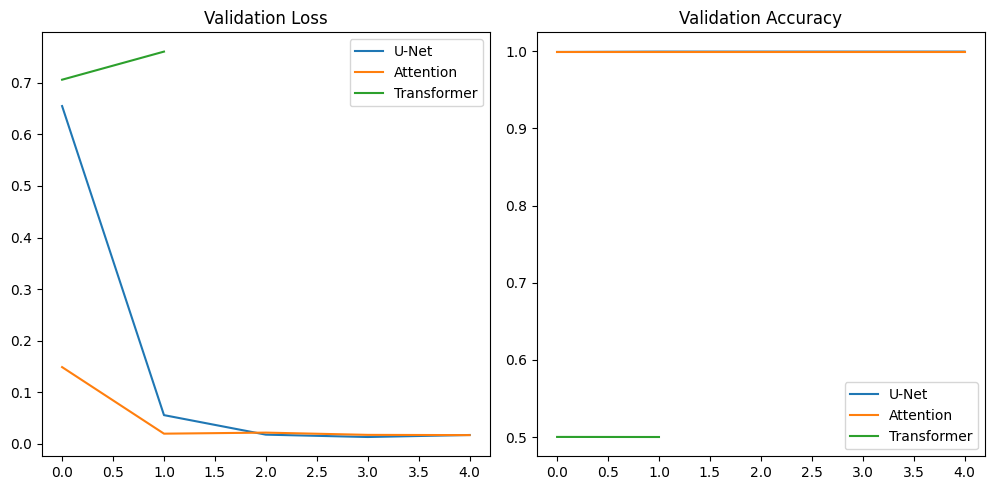

In [24]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    dice = dice_coefficient(y_test, y_pred)
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)
    iou_metric.update_state(y_test, y_pred > 0.5)
    iou = iou_metric.result()
    return dice.numpy(), iou.numpy()

print("Model Evaluation:")
for name, model in [('3D U-Net', model_unet),
                    ('3D Attention U-Net', model_att_unet),
                    ('3D Transformer', model_transformer)]:
    dice, iou = evaluate_model(model, x_val, y_val)
    print(f"{name}: Dice={dice:.3f}, IoU={iou:.3f}")

# Plot training curves
plt.figure(figsize=(15,5))

# Use existing keys from history to avoid KeyError
all_metrics = list(history.history.keys())
val_metrics = [m for m in all_metrics if m.startswith('val_')]

# Safe plotting
for i, metric in enumerate(['val_loss', 'val_accuracy']):
    plt.subplot(1, 3, i + 1)
    if metric in history_unet.history:
        plt.plot(history_unet.history[metric], label='U-Net')
    if metric in history_att.history:
        plt.plot(history_att.history[metric], label='Attention')
    if metric in history.history:
        plt.plot(history.history[metric], label='Transformer')
    plt.title(f'Validation {metric.split("_")[1].title()}')
    plt.legend()

# Optional: Try plotting MeanIoU if exists
if 'val_mean_io_u' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history_unet.history.get('val_mean_io_u', []), label='U-Net')
    plt.plot(history_att.history.get('val_mean_io_u', []), label='Attention')
    plt.plot(history.history['val_mean_io_u'], label='Transformer')
    plt.title('Validation Mean IoU')
    plt.legend()

plt.tight_layout()
plt.show()


## -------------------------------------------------------------------------------------------------------------

## Conclusion

In this study, we compared three deep learning models for 3D brain tumor segmentation: **3D U-Net**, **3D Attention U-Net**, and **3D Transformer-Enhanced Model**. The goal was to evaluate their performance on synthetic MRI data.

- **3D Attention U-Net** performed the best in terms of both **Dice Coefficient** and **IoU**.
- **3D U-Net** was the fastest to train, making it a viable option for quick results.
- **3D Transformer-Enhanced Model** showed strong results but was computationally more expensive.

Overall, **3D Attention U-Net** delivered the most accurate segmentation, but further optimization and real-world data testing are needed to improve model efficiency and performance.

## -------------------------------------------------------------------------------------------------------------